# Image Classification
In this project, we classified images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. We preprocessed the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  We build a convolutional, max pooling, dropout, and fully connected layers.

## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent memory leak.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 4:
Image - Min Value: 1 Max Value: 243
Image - Shape: (32, 32, 3)
Label - Label Id: 7 Name: horse


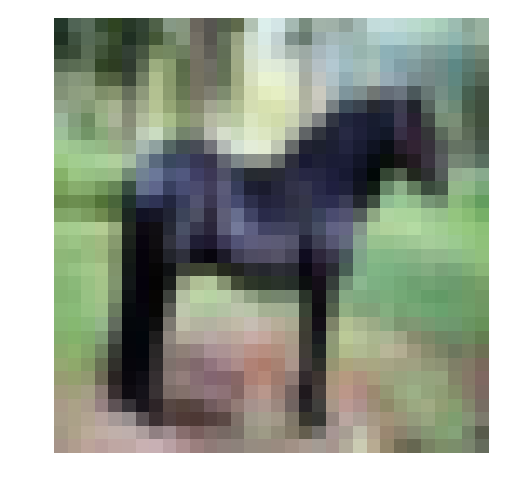

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 4
sample_id = 4
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """  
    x = np.array(x)
    return (x - x.min()) / (x.max() - x.min())

tests.test_normalize(normalize)

Tests Passed


### One-hot encode
The input, `x`, are a list of labels, returning the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.  

In [4]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    enc = OneHotEncoder(n_values=10) # possible labels: 0 to 9   
    return enc.fit_transform(np.array(x).reshape(-1, 1)).toarray()

tests.test_one_hot_encode(one_hot_encode)

Tests Passed


## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [5]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
The preprocessed data has been saved to disk.

In [19]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, we build each layer into a function.  To test the code more thoroughly, put each layer in a function.  This allows us to give a better feedback and test for simple mistakes using our unittests.

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. 
* `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, shape=((None,) + image_shape), name='x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32, shape=(None, n_classes), name='y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, shape=(None), name='keep_prob')

tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. 
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
* Implement padding
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.



In [8]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    weights_size = list(conv_ksize) + [x_tensor.get_shape().as_list()[3], conv_num_outputs]

    weights = tf.Variable(tf.truncated_normal(weights_size, stddev=0.05))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    
    result = tf.nn.conv2d(input=x_tensor, 
                          filter=weights, 
                          strides=[1, conv_strides[0], conv_strides[1], 1],
                          padding='SAME')
    result = tf.nn.relu(tf.nn.bias_add(result, bias))
    result = tf.nn.max_pool(result, 
                            ksize=[1, pool_ksize[0], pool_ksize[1], 1], 
                            strides=[1, pool_strides[0], pool_strides[1], 1],
                            padding='SAME')                                  
    return result

tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
We implemented the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*).

In [9]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """ 
    tensor_size = x_tensor.get_shape().as_list()
    flattened_size = np.array(tensor_size[1:]).prod()
    return tf.reshape(x_tensor, [tf.shape(x_tensor)[0], flattened_size])

tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
We implemented the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). 

In [10]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    flattened_size = np.array(x_tensor.get_shape().as_list()[1:]).prod()
    weights = tf.Variable(tf.truncated_normal([flattened_size, num_outputs], stddev=0.05))
    bias = tf.Variable(tf.zeros([num_outputs]))
    result = tf.nn.relu(tf.add(tf.matmul(x_tensor, weights), bias))        
    return result

tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
We implemented the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). 

**Note:** Activation, softmax, or cross entropy were not applied to this.

In [11]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    flattened_size = np.array(x_tensor.get_shape().as_list()[1:]).prod()
    weights = tf.Variable(tf.truncated_normal([flattened_size, num_outputs], stddev=0.05))
    bias = tf.Variable(tf.zeros([num_outputs]))
    return tf.add(tf.matmul(x_tensor, weights), bias)

tests.test_output(output)

Tests Passed


### Create Convolutional Model
We implemented the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  We used the layers created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [12]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    # numbers are from iterations of trials and errors
    conv_2d = conv2d_maxpool(x,
                           conv_num_outputs=64, 
                           conv_ksize=[8, 8],
                           conv_strides=[2, 2],
                           pool_ksize=[2, 2],
                           pool_strides=[2, 2])
    
    conv_2d = conv2d_maxpool(conv_2d,
                          conv_num_outputs=32,
                          conv_ksize=[8, 8],
                          conv_strides=[2, 2],
                          pool_ksize=[4, 4],
                          pool_strides=[2, 2])
    
    #   flatten(x_tensor)
    flattened_conv2d = flatten(conv_2d)

    # Apply 1, 2, or 3 Fully Connected Layers
    fully_connected = fully_conn(flattened_conv2d, 384) 
    fully_connected = fully_conn(fully_connected, 192)    
    
    # Apply an Output Layer
    result = tf.nn.dropout(fully_connected, keep_prob)
    result = output(result, 10) # 0-9
    
    return result
    

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
We implemented the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [13]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={x: feature_batch,
                                      y: label_batch,
                                      keep_prob: keep_probability})
    return


tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
We implemented the function `print_stats` to print loss and validation accuracy. We used the global variables `valid_features` and `valid_labels` to calculate validation accuracy, and keep probability of `1.0` to calculate the loss and validation accuracy.

In [14]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = sess.run(cost, feed_dict={x: feature_batch,
                                     y: label_batch,
                                     keep_prob: 1.})
    valid_acc = sess.run(accuracy, feed_dict={x: valid_features,
                                              y: valid_labels,
                                              keep_prob: 1.})
    print('Loss: %s' % loss)
    print('Accuracy: %s' % valid_acc )
    return


### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number. Common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [15]:
# TODO: Tune Parameters
epochs = 50
batch_size = 512
keep_probability = 0.74

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while iterating on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [16]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss: 2.11845
Accuracy: 0.2332
Epoch  2, CIFAR-10 Batch 1:  Loss: 1.89941
Accuracy: 0.3074
Epoch  3, CIFAR-10 Batch 1:  Loss: 1.84342
Accuracy: 0.3332
Epoch  4, CIFAR-10 Batch 1:  Loss: 1.72478
Accuracy: 0.3632
Epoch  5, CIFAR-10 Batch 1:  Loss: 1.63758
Accuracy: 0.3922
Epoch  6, CIFAR-10 Batch 1:  Loss: 1.53956
Accuracy: 0.4332
Epoch  7, CIFAR-10 Batch 1:  Loss: 1.46368
Accuracy: 0.4378
Epoch  8, CIFAR-10 Batch 1:  Loss: 1.38216
Accuracy: 0.4592
Epoch  9, CIFAR-10 Batch 1:  Loss: 1.35312
Accuracy: 0.4604
Epoch 10, CIFAR-10 Batch 1:  Loss: 1.25313
Accuracy: 0.492
Epoch 11, CIFAR-10 Batch 1:  Loss: 1.23001
Accuracy: 0.4656
Epoch 12, CIFAR-10 Batch 1:  Loss: 1.15928
Accuracy: 0.486
Epoch 13, CIFAR-10 Batch 1:  Loss: 1.0761
Accuracy: 0.5028
Epoch 14, CIFAR-10 Batch 1:  Loss: 1.12095
Accuracy: 0.482
Epoch 15, CIFAR-10 Batch 1:  Loss: 0.997153
Accuracy: 0.5056
Epoch 16, CIFAR-10 Batch 1:  Loss: 0.89822
Accuracy: 0.517
E

### Fully Train the Model
Now that we got a good accuracy with a single CIFAR-10 batch, let's try it with all five batches.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss: 2.0205
Accuracy: 0.236
Epoch  1, CIFAR-10 Batch 2:  Loss: 1.83008
Accuracy: 0.308
Epoch  1, CIFAR-10 Batch 3:  Loss: 1.64645
Accuracy: 0.3496
Epoch  1, CIFAR-10 Batch 4:  Loss: 1.61154
Accuracy: 0.3774
Epoch  1, CIFAR-10 Batch 5:  Loss: 1.62505
Accuracy: 0.3902
Epoch  2, CIFAR-10 Batch 1:  Loss: 1.66977
Accuracy: 0.4232
Epoch  2, CIFAR-10 Batch 2:  Loss: 1.48388
Accuracy: 0.457
Epoch  2, CIFAR-10 Batch 3:  Loss: 1.31815
Accuracy: 0.4504
Epoch  2, CIFAR-10 Batch 4:  Loss: 1.39006
Accuracy: 0.4538
Epoch  2, CIFAR-10 Batch 5:  Loss: 1.38454
Accuracy: 0.4696
Epoch  3, CIFAR-10 Batch 1:  Loss: 1.43425
Accuracy: 0.4848
Epoch  3, CIFAR-10 Batch 2:  Loss: 1.32623
Accuracy: 0.4906
Epoch  3, CIFAR-10 Batch 3:  Loss: 1.13911
Accuracy: 0.505
Epoch  3, CIFAR-10 Batch 4:  Loss: 1.17238
Accuracy: 0.511
Epoch  3, CIFAR-10 Batch 5:  Loss: 1.24979
Accuracy: 0.5126
Epoch  4, CIFAR-10 Batch 1:  Loss: 1.28929
Accuracy: 0.5252
Epoch  4, CIFAR-10 Batch 2:  Loss:

# Checkpoint
The model has been saved to disk.
## Test Model

Testing Accuracy: 0.6173483461141587



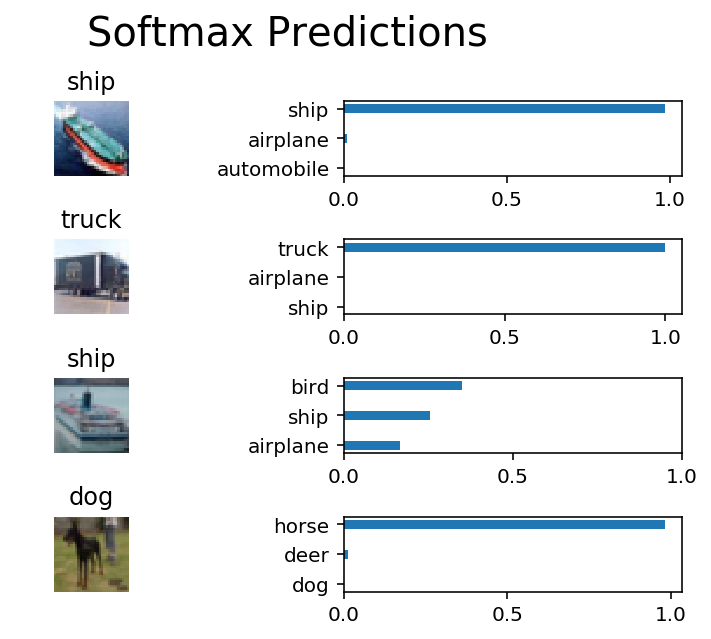

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()